<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/svm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=9b27c033-bc28-445a-9218-d3cdf03c00ee
To: /content/train_dataset.csv
100%|██████████| 110M/110M [00:00<00:00, 232MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy
To: /content/test_dataset.csv
100%|██████████| 18.3M/18.3M [00:00<00:00, 252MB/s]


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    5    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    9    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Training data shape: (60000, 784)
Test data shape: (10000, 784)


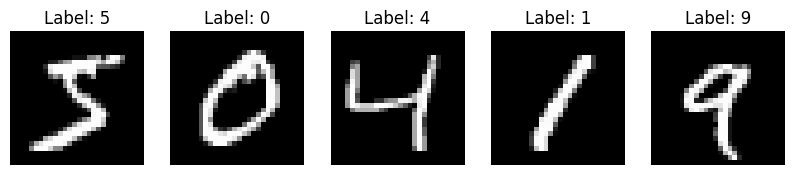

In [1]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

#----------------------------------------------------------------------
# file import from derive
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"


# downloading file
train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)


# dataframe formation
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)


print(train_df.head())
#----------------------------------------------------------------------

# making y = label(1st column) and x = row (other column).

#for train dataset
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values  # Features (pixel values)

#for test dataset
y_test = test_df.iloc[:, 0].values  # Labels
X_test = test_df.iloc[:, 1:].values  # Features (pixel values)

# normalize pixel values (0-255 → 0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# shape of train and test
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

#----------------------------------------------------------------------

# displaying some images.|
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")

plt.show()

In [2]:
class FastMultiClassSVM:
    def __init__(self, learning_rate=0.015, lambda_param=0.008, epochs=400, batch_size=512):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.batch_size = batch_size
        self.classes = None
        self.models = {}
        self.total_cost = 0

    def compute_cost(self, X, y, W, b):
        """Compute hinge loss with regularization."""
        margins = 1 - y * (np.dot(X, W) + b)
        margins[margins < 0] = 0
        hinge_loss = np.mean(margins)
        regularization = self.lambda_param * np.linalg.norm(W) ** 2
        return regularization + hinge_loss

    def fit(self, X, y):
        self.classes = np.unique(y)
        m, n = X.shape

        total_cost = 0

        for digit in self.classes:
            y_binary = np.where(y == digit, 1, -1)

            W = np.zeros(n)
            b = 0

            for epoch in range(self.epochs):
                indices = np.random.permutation(m)
                X_shuffled, y_shuffled = X[indices], y_binary[indices]

                for batch_start in range(0, m, self.batch_size):
                    batch_end = batch_start + self.batch_size
                    X_batch = X_shuffled[batch_start:batch_end]
                    y_batch = y_shuffled[batch_start:batch_end]

                    margins = y_batch * (np.dot(X_batch, W) + b)
                    misclassified = margins < 1

                    W_gradient = 2 * self.lambda_param * W - np.dot(y_batch[misclassified], X_batch[misclassified])
                    b_gradient = -np.sum(y_batch[misclassified])

                    W -= self.learning_rate * W_gradient / self.batch_size
                    b -= self.learning_rate * b_gradient / self.batch_size

            total_cost += self.compute_cost(X, y_binary, W, b)

            self.models[digit] = (W, b)

        self.total_cost = total_cost

    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))

        for i, digit in enumerate(self.classes):
            W, b = self.models[digit]
            scores[:, i] = np.dot(X, W) + b

        return self.classes[np.argmax(scores, axis=1)]


In [3]:
from sklearn.metrics import accuracy_score

learning_rates = [0.02, 0.05, 0.1]  # Optimized learning rates
total_costs = []
accuracies = []

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = FastMultiClassSVM(learning_rate=lr, lambda_param=0.008, epochs=400, batch_size=512)
    model.fit(X_train, y_train)

    # Store total cost
    total_costs.append(model.total_cost)

    # Predict on test data & calculate accuracy
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Accuracy for learning rate {lr}: {acc:.4f}")



Training with learning rate: 0.02
Accuracy for learning rate 0.02: 0.9212

Training with learning rate: 0.05
Accuracy for learning rate 0.05: 0.9218

Training with learning rate: 0.1
Accuracy for learning rate 0.1: 0.9227


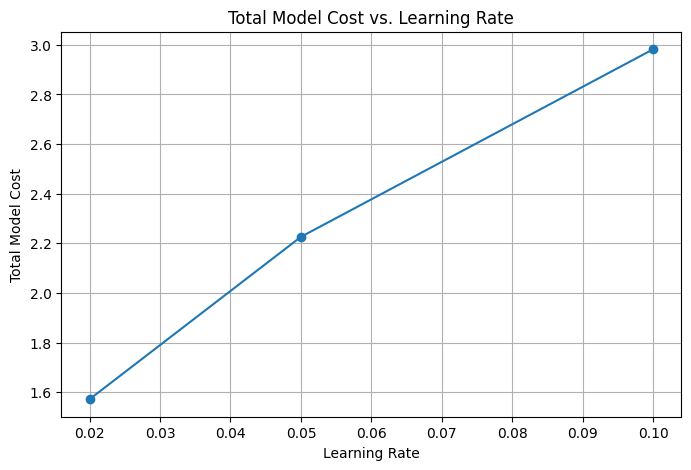

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, total_costs, marker='o', linestyle='-')
plt.xlabel("Learning Rate")
plt.ylabel("Total Model Cost")
plt.title("Total Model Cost vs. Learning Rate")
plt.grid(True)
plt.show()


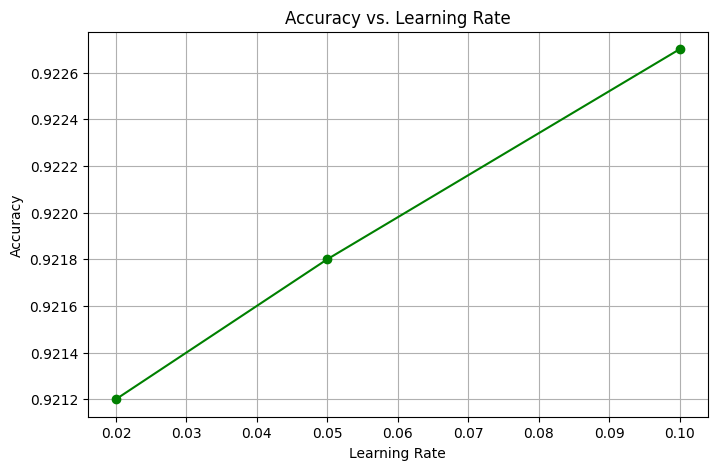

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, accuracies, marker='o', linestyle='-', color='g')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Learning Rate")
plt.grid(True)
plt.show()
